In [1]:
import sys
sys.path.append("../codesearchnet")

import os.path as osp

import argparse
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.utils import train_test_split_edges

import swifter

from code_parser import *
from data_reader import get_data_df

## Read Data

In [3]:
df = get_data_df("../resources/data/", ["python"] , ["train"])
print(len(df))

412178


In [4]:
def _code_parse(row):
    parser_ = get_parser(lang=row['language'], so_path="../resources/csnet_parse_build.so")
    g_ = parse_program(row['code'], parser=parser_)
    return g_

In [7]:
df.reset_index(drop=True)
g_s = df.swifter.apply(_code_parse, axis=1)
g_s = list(g_s)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [41]:
# big_g = nx.disjoint_union_all(list(g_s))

In [10]:
import fasttext as ft

In [34]:
model = ft.train_unsupervised(
    "../resources/python_processed/code_corpus.txt",
    lr = 0.005,
    epoch = 10,
    ws = 10,
    minCount = 10,
    dim = 256,
    thread = 40,
)

In [35]:
model.save_model("../resources/python_processed/code_ft.bin")

In [17]:
embed = ft.load_model("../resources/python_processed/code_ft.bin")

In [36]:
print(model.get_nearest_neighbors('self'))

[(0.7811248898506165, '(self'), (0.7505491971969604, '.'), (0.7483435273170471, 'attribute'), (0.7307307124137878, 'oself'), (0.7233479022979736, 'myself'), (0.6956260204315186, '_self'), (0.6935381293296814, 'zelf'), (0.6858091950416565, 'nself'), (0.6429136395454407, 'selfDim'), (0.6330493092536926, '__self')]


In [37]:
print(model.get_nearest_neighbors('open'))

[(0.8480510711669922, 'zopen'), (0.8409914970397949, 'openpnm'), (0.8142781257629395, 'nopen'), (0.8124527931213379, 'fdopen'), (0.8104597926139832, 'open_zip'), (0.7974083423614502, 'open_fs'), (0.789747416973114, 'open_'), (0.7818751335144043, 'openpty'), (0.7743011116981506, 'openvr'), (0.770271897315979, 'lopen')]


## Data for torch_geometric

In [29]:
from torch_geometric.data import Data,Dataset, DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.utils import train_test_split_edges

from livelossplot import PlotLosses

In [30]:
def get_data_from_graph(g: nx.DiGraph, y=None) -> Data:
    graph_spicy = nx.to_scipy_sparse_matrix(g, format='coo')
    edge_index = torch.tensor([graph_spicy.row, graph_spicy.col], dtype=torch.long)
    
    x = torch.tensor([embed[x.name] for x in g.nodes()], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index)

    return data

In [43]:
class CodeDataset(Dataset):
    def __init__(self, g_s):
        self.g_s = g_s
        self.data = {}
        super(CodeDataset, self).__init__()

    def len(self):
        return len(self.g_s)

    def get(self, idx):
        if not idx in self.data:
            data = get_data_from_graph(g_s[idx])
            data.train_mask = data.val_mask = data.test_mask = data.y = None
            data = train_test_split_edges(data, val_ratio=0.0, test_ratio=0.2)
            self.data[idx] = data
        return self.data[idx]

In [44]:
dataset = CodeDataset(g_s)

In [45]:
dataset[0]

Data(test_neg_edge_index=[2, 8], test_pos_edge_index=[2, 8], train_neg_adj_mask=[44, 44], train_pos_edge_index=[2, 70], val_neg_edge_index=[2, 0], val_pos_edge_index=[2, 0], x=[44, 256])

In [48]:
from torch_geometric.nn import GCNConv, GAE, VGAE
import torch.nn.functional as F
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 4 * out_channels)
        self.conv2 = GCNConv(4 * out_channels, 2 * out_channels)
        if True:
            self.conv_mu = GCNConv(2 * out_channels, out_channels)
            self.conv_logvar = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        if True:
            return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)


In [49]:
model = VGAE(Encoder(dataset.num_features, 64))

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [51]:
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

def test(data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x,  data.train_pos_edge_index)
    return model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

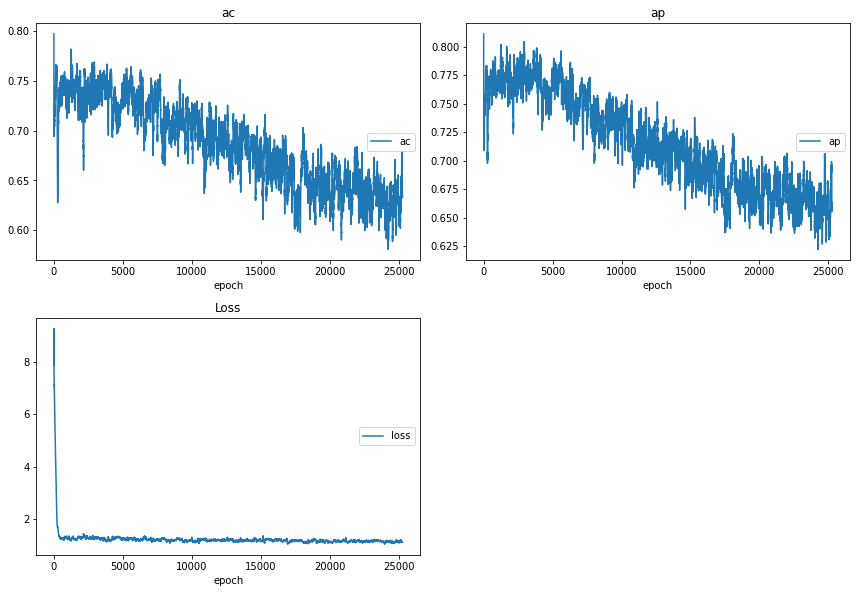

ac
	ac               	 (min:    0.000, max:    1.000, cur:    0.634)
ap
	ap               	 (min:    0.365, max:    1.000, cur:    0.659)
Loss
	loss             	 (min:    0.960, max:   11.338, cur:    1.127)


In [ ]:
liveloss = PlotLosses()
logs = {}

losses = []
test_acs, test_aps = [], []

for epoch in range(10):
    
    for ii, data in enumerate(dataset):
        loss = train(data)
        losses.append(loss)
        
        logs['loss'] = np.mean(losses[-50:])


        test_ac, test_ap = test(data)

        test_acs.append(test_ac)
        test_aps.append(test_ap)
        
        logs['ac'] = np.mean(test_acs[-50:]) 
        logs['ap'] = np.mean(test_aps[-50:]) 
        
        liveloss.update(logs)
        liveloss.send()

        print('Epoch: {:03d}, Iteration: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, ii, np.mean(losses[-50:]), np.mean(test_acs[-50:]), np.mean(test_aps[-50:])), end="\r")